# 6233 Option Pricing and StochasticCalculus in Finance
# Final Project: Two Assets Correlation Options

## Individual Model Test on Historical Data of Stock1:PG   Stock2:BBY
### Conducted by Zicheng He   zh1345


In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.integrate import dblquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


### Pricing Option Value

In [2]:
# Function to price option
def M(a,b,rho):
    """
    double intergral M in pricing
    
    """
    coef =  1/(2*np.pi*np.sqrt(1-rho**2))
    dbintergral = dblquad(lambda y,x:np.exp((-x**2 + 2*rho*x*y - y**2)/(2 - 2*rho**2)), ##f
                          -np.inf,       ## x lower bound
                          b,             ## x upper bound
                          -np.inf,       ## y lower bound
                          a)[0]          ## y upper bound
    return coef * dbintergral


def Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao): #定价方程
    """
    Payoff:max(S2(T)-K2,0) if S1(T)>K1  otherwise 0
    
    """
    y2 = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))  # y2 = dz
    y1 = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))  # y1 = dx
    V = S2 * M(y2 + sigma2*np.sqrt(tao), y1 + rho*sigma2*np.sqrt(tao), rho) - K2 * np.exp(-r*tao) * M(y2,y1,rho)
    return V

### Calculate Analytical Delta

In [3]:
## Analytical Delta
def dM1(a,b,S1,sigma1,rho,tao):
    f = lambda z: np.exp((-b**2 + 2*rho*b*z -z**2)/(2 - 2*rho**2)) / (sigma1 * np.sqrt(tao) * S1)
    dmds1 = quad(f, -np.inf, a)[0]/(2 * np.pi * (1-rho**2))
    return dmds1

def dM2(a,b,S2,sigma2,rho,tao):
    f = lambda x: np.exp((-a**2 + 2*rho*a*x -x**2)/(2 - 2*rho**2)) / (sigma2 * np.sqrt(tao) * S2)
    dmds2 = quad(f, -np.inf, b)[0]/(2 * np.pi * (1-rho**2))
    return dmds2
    

def Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao):
    dz = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))
    dx = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))
    A = dM1(dz + sigma2*np.sqrt(tao), dx  + rho*sigma2*np.sqrt(tao), S1, sigma1, rho, tao)
    B = dM1(dz, dx, S1, sigma1, rho, tao)
    D1 = S2 * A - K2 * np.exp(-r*tao) * B
    return D1

def Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao):
    dz = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))
    dx = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))
    C = dM2(dz + sigma2*np.sqrt(tao), dx  + rho*sigma2*np.sqrt(tao), S2, sigma2, rho, tao)
    D = dM2(dz, dx, S2, sigma2, rho, tao)
    D2 = M(dz+sigma2*np.sqrt(tao), dx+rho*sigma2*np.sqrt(tao), rho) + S2 * C - K2 * np.exp(-r*tao) * D
    return D2

### Analytical solution on historical data on specific stock

In [4]:
# Read data, change path here to load  data
path1 = 'PG.csv'
path2 = 'BBY.csv'

# Calculate annulized vol (sigma1,sigma2) and rho
df1 = pd.read_csv(path1,usecols=['Date','Close'],index_col=0).rename(columns={'Close': 'First'})
df1['firlogret']=np.log(df1.First) - np.log(df1.First.shift(1))
sigma1 = np.std(df1['firlogret'])*(252**0.5)

df2 = pd.read_csv(path2,usecols=['Date','Close'],index_col=0).rename(columns={'Close': 'Second'})
df2['seclogret']=np.log(df2.Second) - np.log(df2.Second.shift(1))
sigma2 = np.std(df2['seclogret'])*(252**0.5)

df = df1.merge(df2, left_index=True, right_index=True)
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]

# set up K, tao, r
K1, K2 = df['First'][0],df['Second'][0]
r = 0.0083
df['tao'] = range(252,0,-1) 
df['tao'] = df['tao'] /252

# Price option on each day's stocks price
df['OptionPrice'] = 0
for index, row in df.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao    
    df.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)

In [5]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice
Date,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423


In [6]:
# Monte Carlo Pricing
def SimulateSP(sigma1,sigma2,T,S0_1,S0_2,r,delta,rho):
    stockprice1 = []
    stockprice2 = []
    stockprice1.append(S0_1)
    stockprice2.append(S0_2)
    S2 = S0_2
    S1 = S0_1
    for i in range(delta):
        w1 = np.random.normal(0,math.sqrt(T/delta))
        w2 = np.random.normal(0,math.sqrt(T/delta))
        w3 = rho*w1+np.sqrt(1-rho**2)*w2
        deltaprice1 = (r-0.5*sigma1**2)*(T/delta)+sigma1*w1
        deltaprice2 = (r-0.5*sigma2**2)*(T/delta)+sigma2*w3
        S1 = S1 * np.exp(deltaprice1)
        S2 = S2 * np.exp(deltaprice2)
        stockprice1.append(S1)
        stockprice2.append(S2)
    return stockprice1,stockprice2
         

def PricingByMc(K_1,K_2,r,T, s1, s2, sigma1, sigma2, rho):
    twoassetprice = []
    for i in range(10000):
        stockprice1,stockprice2 = SimulateSP(sigma1,sigma2,T,s1,s2,r,252,rho)
        if stockprice1[-1] > K_1:
            twoassetprice.append(max(stockprice2[-1]-K_2,0)*np.exp(-r*T))
        else:
            twoassetprice.append(0)
    return np.mean(twoassetprice)

df_mc = df.copy()
df_mc['MCprice'] = 0
count = 0
for index, row in df_mc.iterrows():
    count +=1
    S1 = row.First
    S2 = row.Second
    tao = row.tao    
    df_mc.loc[index,'MCprice'] = PricingByMc (K1, K2, r, tao, S1, S2, sigma1, sigma2, rho)
    if count == 6:  ### just show some cases here, otherwise it may take too much time
        break
    print (count)

1
2
3
4
5


In [7]:
df_mc.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,MCprice
Date,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912,10.475882
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852,11.562861
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076,11.113263
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546,11.349464
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423,11.653102


In [8]:
# Delta From Analytics
df['Delta1'] = 0
df['Delta2'] = 0
for index, row in df.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao    
    df.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)

In [9]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912,0.158523,0.420789
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852,0.158300,0.434901
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076,0.163223,0.431378
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546,0.163141,0.429932
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423,0.177416,0.428924


In [10]:
# Delta From Numerics
df_num = df.copy()
df_num['NumDelta1'] = 0
df_num['NumDelta2'] = 0
chg = 0.1
for index, row in df_num.iterrows():
    S1 = row.First
    S1up = row.First + chg
    S1down = row.First - chg
    S2 = row.Second
    S2up = row.Second + chg
    S2down = row.Second - chg
    tao = row.tao  
    df_num.loc[index,'NumDelta1'] = (Pricing_Correlation_Option(S1up, S2, K1, K2, sigma1, sigma2, r, rho, tao) 
                           - Pricing_Correlation_Option(S1down, S2, K1, K2, sigma1, sigma2, r, rho, tao)) / (2 * chg)
    df_num.loc[index,'NumDelta2'] = (Pricing_Correlation_Option(S1, S2up, K1, K2, sigma1, sigma2, r, rho, tao) 
                           - Pricing_Correlation_Option(S1, S2down, K1, K2, sigma1, sigma2, r, rho, tao)) / (2 * chg)

In [11]:
df_num.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,NumDelta1,NumDelta2
Date,,,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912,0.158523,0.420789,0.134419,0.420789
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852,0.158300,0.434901,0.134230,0.434901
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076,0.163223,0.431378,0.138404,0.431378
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546,0.163141,0.429932,0.138335,0.429932
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423,0.177416,0.428924,0.150439,0.428924


Comparing the Deltas from numerics and analytics, I found that the Analytical Delta1 is little bit larger than Numerical Delta1 and Delta2 are exactly same for both.

## 3. Test the stock on extreme cases
### Case 1. Zero correlation, correlation = 0
### Case 2. Perfect correlation, correlation = 1

In [12]:
## Validation process:
### 3. Extreme cases
# reset params, using historical data
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]

K1, K2 = df['First'][0],df['Second'][0]
r = 0.0083

df_test1 = df.copy()
df_test2 = df.copy()

### case1. zero correlation, correlation = 0
df_test1["rho"] = 0
for index, row in df_test1.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao 
    rho = row.rho
    df_test1.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test1.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test1.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
     
### case2. perfect correlation, correlation = 1
df_test2["rho"] = 0.99 # when rho = 1, formula divide by 0, and we get NaN, so try 0.99 here 
for index, row in df_test2.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao
    rho = row.rho
    df_test2.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test2.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test2.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    


D:\Coding\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
D:\Coding\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


In [13]:
df_test1.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,rho
Date,,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,6.177821,0.157013,0.270054,0
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,6.635761,0.161758,0.284155,0
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,6.571296,0.163769,0.280507,0
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,6.515765,0.163277,0.279217,0
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,6.653214,0.172064,0.277766,0


In case1, when correlation equals 0, delta1 is not moving much but delta2 bacomes much smaller than in the original setting

In [14]:
df_test2.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,rho
Date,,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,13.864211,0.055471,0.598878,0.99
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,14.378648,0.046075,0.609748,0.99
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,14.461860,0.062246,0.609369,0.99
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,14.378344,0.063063,0.608083,0.99
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,15.015848,0.120554,0.612061,0.99


In case2, when correlation is close to 1, I found delta1 tends to be close to zero and delta2 becomes larger than in the original rho

### Case3. S1 << K1

In [15]:
### 3. S1 << K1
df_test3 = df.copy()
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]
K1 = 1000

for index, row in df_test3.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao 
    #rho = row.rho
    df_test3.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test3.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test3.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)

In [16]:
df_test3.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,5.840463e-10,1.345148e-10,1.015571e-11
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,7.079840e-10,1.606462e-10,1.214917e-11
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,5.681261e-10,1.305778e-10,9.709950e-12
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,5.032917e-10,1.163272e-10,8.614141e-12
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,3.842114e-10,9.032021e-11,6.446333e-12


When S1<<K1, our option is hard to be activated, and it will be nearly worthless. The result confirms our hypothesis, and I can see that Delta 1, Delta 2, and option price are all tend to 0.

### Case4. S1 >> K1

In [17]:
### 4. S1 >> K1
df_test4 = df.copy()
df_test4['VanillaOptionPrice'] = 0
df_test4['VanillaOptionDelta2'] = 0
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]
K1 = 5 

def Pricing_Vanilla_Call(S,K,sigma,T,r):
    d1 = (math.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*math.sqrt(T))
    d2 = d1-sigma*math.sqrt(T)
    C = S*stats.norm.cdf(d1,0,1)- np.exp(-r*T)*K*stats.norm.cdf(d2,0,1)
    return C,stats.norm.cdf(d1,0,1)

for index, row in df_test4.iterrows():
    S1 = row.First  
    S2 = row.Second
    tao = row.tao 
    #rho = row.rho
    df_test4.loc[index,'VanillaOptionPrice'] = Pricing_Vanilla_Call(S2,K2,sigma2,tao,r)[0]  
    df_test4.loc[index,'VanillaOptionDelta2'] = Pricing_Vanilla_Call(S2,K2,sigma2,tao,r)[1]  
    df_test4.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test4.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test4.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)


In [18]:
df_test4.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,VanillaOptionPrice,VanillaOptionDelta2
Date,,,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,13.883722,2.003736e-29,0.606905,13.883722,0.606905
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,14.394566,1.099686e-29,0.616400,14.394566,0.616400
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,14.484283,1.152425e-29,0.618286,14.484283,0.618286
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,14.401041,9.225453e-30,0.617121,14.401041,0.617121
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,15.064838,1.323493e-29,0.628945,15.064838,0.628945


On the last case, when the strike price K1 is extremely small, we assume that the barrier will become useless, and our option will become a vanilla option based on S2. The result confirms our hypothesis, and I see that Delta 2 of our option is pretty close to Delta 2 of a vanilla call option.  

## 4. Values vs Correlation

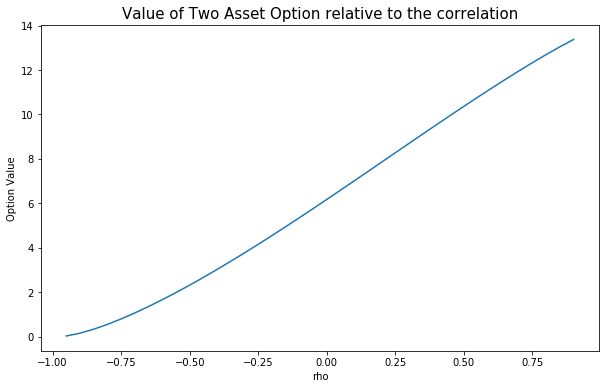

In [19]:
### 4. values vs correlation
def twoassetvalue_rho(rho):
    return Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
S1 = df.First[0]
S2 = df.Second[0]
K1 = S1
K2 = S2
tao = 1

x = np.arange(-0.95,0.95, 0.05)
y = []
for i in x:
    y.append(Pricing_Correlation_Option(S1,S2,K1,K2,sigma1,sigma2,r,i,tao))
fig0 = plt.figure(figsize=(10,6))
plt.title("Value of Two Asset Option relative to the correlation",fontsize = 15)
plt.xlabel('rho')
plt.ylabel('Option Value')
plt.plot(x,y)
plt.show()

Option value is monotonic increasing as correlation increase

## BackTest model on specific stocks with PnL

In [20]:
# BackTest : Pnl calculation
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912,0.158523,0.420789
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852,0.158300,0.434901
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076,0.163223,0.431378
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546,0.163141,0.429932
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423,0.177416,0.428924


In [21]:
df['PNL'] = 0
df['PNL_Option'] = df['OptionPrice'] - df['OptionPrice'].shift(1)
df['Price_diff1'] = df['First'] - df['First'].shift(1)
df['Price_diff2'] = df['Second'] - df['Second'].shift(1) 
df['PNL_Hedge'] = df['Delta1'].shift(1) * df['Price_diff1'] + df['Delta2'].shift(1) * df['Price_diff2']
df['PNL'] = df['PNL_Option'] - df['PNL_Hedge']

In [22]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,PNL,PNL_Option,Price_diff1,Price_diff2,PNL_Hedge
Date,,,,,,,,,,,,,
2019-05-15,106.699997,NaN,67.860001,NaN,1.000000,10.610912,0.158523,0.420789,NaN,NaN,NaN,NaN,NaN
2019-05-16,108.110001,0.013128,68.739998,0.012884,0.996032,11.155852,0.158300,0.434901,-0.048871,0.544940,1.410004,0.879997,0.593811
2019-05-17,107.449997,-0.006124,68.930000,0.002760,0.992063,11.127076,0.163223,0.431378,-0.006930,-0.028777,-0.660004,0.190002,-0.021846
2019-05-20,107.330002,-0.001117,68.839996,-0.001307,0.988095,11.050546,0.163141,0.429932,-0.018118,-0.076530,-0.119995,-0.090004,-0.058412
2019-05-21,106.370003,-0.008985,69.949997,0.015996,0.984127,11.367423,0.177416,0.428924,-0.003733,0.316877,-0.959999,1.110001,0.320610


Text(0.5, 1.0, 'PnL from Option and Hedge Part')

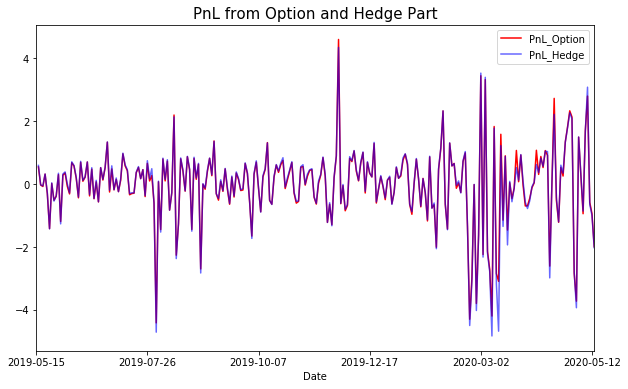

In [23]:
fig1 = plt.figure(figsize=(10,6))
df['PNL_Option'].plot(c='r',label='PnL_Option')
df['PNL_Hedge'].plot(c='b',alpha=0.6,label='PnL_Hedge')
plt.legend()
plt.title("PnL from Option and Hedge Part",fontsize = 15)

Text(0.5, 1.0, 'Total PnL from Hedged Portfolio')

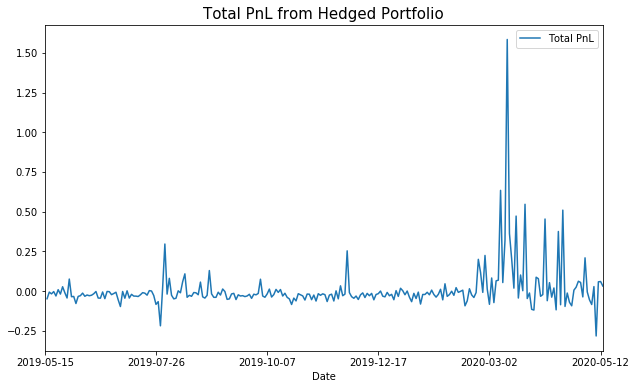

In [24]:
fig2 = plt.figure(figsize=(10,6))
df['PNL'].plot(label='Total PnL')
plt.legend()
plt.title("Total PnL from Hedged Portfolio",fontsize = 15)

In the first graph, I plot the different side of position into red (Two-Asset Option) and blue (Two Stocks). In the second graph, we draw out the curve of the difference, which refers to the Total PnL. It is apparent that, although from march, the PnL becomes volatile(because the market is volatile due to the COVID-19), before that time, the PnL is close to zero. The PnL refers to the difference between Long and Short Position. If we Long Two-Asset options and Short with Stocks, we should use simulated delta to hedge it. To test the comparative accuracy of Delta and Two-Asset Option simulation results, we use PnL to find the difference of opposite positions. The conclusion is our Pricing Model is proved to be accurate in this stock.